# Runner

In [24]:
from utils.setting import config
import numpy as np
from model.sampler import GaussianMixtureSampler
import numpy as np
import matplotlib.pyplot as plt
from model.conformal_dra import ConformalizedDecisionRiskAssessment
from model.naive_dra import NaiveDecisionRiskAssessment
from model.opt import Optimization
from model.ro import RobustOptimization
from model.spo import SPO
from model.dfl import DFL

In [51]:
def synthetic_decision(mu, scale, weights, ntr, ncal, nte, k, A, b, lr = 1e-1, niter = 100,
                       verbose = False, save_folder = None, return_all_decision = False):

    sampler_kwds = {
        'mu':       mu,     # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    scale,  # [ ncomp ] np, the variance of GMs 
        'weights':  weights # [ ncomp ]
    }
    sampler     = GaussianMixtureSampler(**sampler_kwds)
    true_kwds = {
        'A':    A,
        'b':    b,
        'kwds': sampler_kwds,
        'boundary_scale':   10
    }
    true_dra        = NaiveDecisionRiskAssessment(**true_kwds)
    all_decisions   = true_dra.vertices

    Ytr         = sampler.sample(ntr)       # [ ntr, data_dim ]
    Ycal        = sampler.sample(ncal)      # [ ncal, data_dim ]
    Yte         = sampler.sample(nte)       # [ nte, data_dim ]
    Y = np.concatenate([Ytr, Ycal], 0)      # [ ntr + ncal, data_dim ], this is the extended training data for methods that don't need calibration

    '''Ground truth (z_real for Yte)'''
    z_real = []
    for i in range(nte):
        kwds  = {
            'A':    A,
            'b':    b,
            'Y':    Yte[i]
        }
        opt = Optimization(**kwds)
        z_real_  = opt.get_action()
        z_real.append(z_real_)
    z_real = np.array(z_real)               # [ nte, z_dim ] 

    '''Our method'''
    placeholder_kwds = {
        'mu':       np.zeros(sampler_kwds['mu'].shape),
        'scale':    np.ones(sampler_kwds['scale'].shape),                                 # [ ncomp ] np, the variance of GMs 
        'weights':  np.ones(sampler_kwds['scale'].shape) / len(sampler_kwds['scale']),    # [ ncomp ] np, the variance of GMs 
    }
    pred_sampler = GaussianMixtureSampler(**placeholder_kwds)
    model_kwds = pred_sampler.fit(Ytr, n_iter=100, return_kwds=True)
    kwds = {
        'A':    A,
        'b':    b,
        'kwds': model_kwds,
        'boundary_scale':   10
    }
    dra         = ConformalizedDecisionRiskAssessment(**kwds)
    dra.calibrate(Ycal)
    a = dra.get_prob(K = k)         # [ num_decision ]
    a = all_decisions[np.argmax(a)] # [ z_dim ], the final decision

    '''PTO / Naive Prediction'''
    kwds  = {
        'A':    A,
        'b':    b,
        'Y':    Y.mean(0)
    }
    opt = Optimization(**kwds)
    b_  = opt.get_action()  # [ z_dim ], the final decision

    '''Robust Optimization (uncertainty region determined by CP)'''
    Y_pred  = Ytr.mean(0)
    scores  = np.linalg.norm(Y_pred[None, :] - Ycal, ord = np.inf, axis=1) # [ ncal ] 
    q       = np.quantile(scores, 0.95)   # scalar  
    kwds  = {
        'A':    A,
        'b':    b,
        'C':    np.array([
            [1,     0],
            [-1,    0],
            [0,     1],
            [0,    -1]
        ]),
        'd':    np.array([Y_pred[0] + q, -Y_pred[0] + q, Y_pred[1] + q, -Y_pred[1] + q])
    }
    ro = RobustOptimization(**kwds)
    d_ = ro.get_action()

    '''Smart Predict-Then-Optimize (SPO)'''
    kwds  = {
        'A':    A,
        'b':    b,
        'verbose':  verbose
    }
    fit_kwds = {
        'Y':        Y,
        'lr':       lr,
        'niter':    niter,
        'save_folder':  save_folder
    }

    spo = SPO(**kwds)
    Y_hats = spo.fit(**fit_kwds) # trajectories of estimated Yhat
    e = spo.get_action()

    '''Decision Focused Learning (DFL)'''
    kwds  = {
        'A':    A,
        'b':    b,
        'verbose':  verbose
    }
    fit_kwds = {
        'Y':        Y,
        'lr':       lr,
        'niter':    niter,
        'patience': niter # TODO
    }
    dfl = DFL(**kwds)
    Y_hats = dfl.fit(**fit_kwds)
    f = dfl.get_action()

    if not return_all_decision:
        return a, b_, d_, e, f, z_real  # CREDO, PTO, RO, SPO+, DFL are [ z_dim ], real_decisions [ nte, z_dim ]
    else:
        return a, b_, d_, e, f, z_real, all_decisions


def empirical_decision_rank(z_est, z_real):
    '''
    Compute EDC metric
    Args:
    - z_est:    [ z_dim ]               estimated decision
    - z_real:   [ batch_size, z_dim ]   real optimal decision using unseen data
    '''
    unique_vals, counts =   np.unique(z_real, return_counts=True, axis=0)
    sorted_indices =        np.argsort(-counts)  # use -counts for descending order
    sorted_unique_vals =    unique_vals[sorted_indices]
    mask =                  sorted_unique_vals == z_est
    mask =                  mask.all(1)
    try:
        index = np.where(mask)[0].item() + 1 # plus one to align with the notion of ranking
    except:
        index = len(mask)   # this is a rather "generous"assignment 
    return index

def count_decision(item, all_decisions):
    '''
    Args:
    - item:             [ ntrail, z_dim ]
    - all_decisions:    [ num_decisons, z_dim ]
    '''
    # [ niter, dim ] versus [ ndecisions, dim ] -> [ niter, ndecisions ]
    mask    = (item[:, None, :] == all_decisions[None, :, :]).all(axis=2)
    count   = mask.sum(0) # [ num_decisions ]
    return count    # [ num_decisions ]

# Setting I

## $\sigma = 10^{-1}$

In [23]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1]) * 1e-1,          # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([1.0]),               # [ ncomp ]
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [1,    1],
            [-1,   0],
            [0,   -1]
        ]),
        'b':    np.array([1, 0, 0]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_1_sigma_10n1/iter_{i}' 
    }
    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


In [28]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 1.94 \pm 0.86
PTO: 1.00 \pm 0.00
RO: 1.00 \pm 0.00
SPO+: 1.00 \pm 0.00
DFL: 2.33 \pm 0.65


## $\sigma = 1$

In [48]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1]),          # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([1.0]),               # [ ncomp ]
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [1,    1],
            [-1,   0],
            [0,   -1]
        ]),
        'b':    np.array([1, 0, 0]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_1_sigma_1/iter_{i}' 
    }
    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'synthetic_decision' is not defined

In [ ]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 1.61 \pm 0.56
PTO: 2.76 \pm 0.59
RO: 2.98 \pm 0.14
SPO+: 2.68 \pm 0.65
DFL: 1.83 \pm 0.81


## $\sigma = 10^1$

In [33]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1]) * 10,          # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([1.0]),               # [ ncomp ]
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [1,    1],
            [-1,   0],
            [0,   -1]
        ]),
        'b':    np.array([1, 0, 0]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_1_sigma_10p1/iter_{i}' 
    }
    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


In [34]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 1.55 \pm 0.52
PTO: 2.06 \pm 0.81
RO: 3.00 \pm 0.00
SPO+: 2.03 \pm 0.82
DFL: 1.96 \pm 0.84


## Freq vs. Decision

In [58]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[-1e-1, -1e-1]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1]),          # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([1.0]),               # [ ncomp ]
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [1,    1],
            [-1,   0],
            [0,   -1]
        ]),
        'b':    np.array([1, 0, 0]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_1_sigma_1/iter_{i}',
        'return_all_decision': True
    }
    a, b, c, d, e, z_real, all_decisions = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


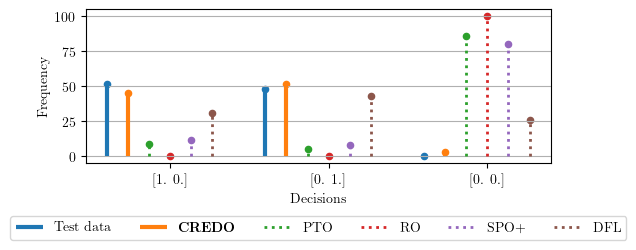

In [107]:
import matplotlib.pyplot as plt

scale = 0.8
name = ['Test data', r'\textbf{CREDO}', 'PTO', 'RO', 'SPO+', 'DFL']
cmap = plt.cm.tab10

plt.figure(figsize=[6, 2])
ax = plt.gca()
xs = np.arange(len(all_decisions))
for i in range(len(results)):   # [ num_decisions ]
    if i != 0:
        item =  results[i - 1]
    else:
        item = []
        for j in range(100):
            mask = results[-1][j, :, :][:, None, :] == all_decisions[None, :, :] # [ nte, num_decisions, z_dim ]
            mask = mask.all(2)      # [ nte, num_decisions ]
            mask    = mask.sum(0)   # [ num_decisions ]
            index   = mask.argmax()
            item.append(all_decisions[index])
        item = np.array(item)
    count = count_decision(item, all_decisions)
    for j in range(len(xs)):
        ax.vlines(x = xs[j] - 0.5 * scale + i * scale / len(results),
                ymin = 0,
                ymax = count[j],
                color = cmap(i),
                lw = 3 if i <= 1 else 2,
                ls = '-' if i <= 1 else 'dotted',
                label = name[i] if j == 0 else None)
    ax.scatter(xs - 0.5*scale + i * scale / len(results),
               count, color=cmap(i), s = 20)
ax.set_ylabel('Frequency')
ax.set_xticks(xs, all_decisions)
ax.set_xlabel('Decisions')
ax.grid(axis='y')
plt.legend(bbox_to_anchor = [0.5, -0.3], ncol = 6,  loc = 'upper center')
plt.show()

# Setting II

## $\sigma = 10^{-1}$

In [47]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[0.0, -0.8],
                            [-0.5, 0.25],
                            [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-2, 3e-2, 2e-2]) * 0.1,                                # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [-1/2, -1],
            [0,   -1],
            [-1/2, 1],
            [1/2,  1],
            [2,   -1],
            [1, 0],
            [0, 1],
            [-1, 0]
        ]),
        'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_2_sigma_10n1/iter_{i}'
    }

    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


In [48]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 1.05 \pm 0.22
PTO: 3.55 \pm 0.50
RO: 4.99 \pm 0.10
SPO+: 3.95 \pm 1.20
DFL: 3.60 \pm 1.52


## $\sigma = 1$

In [49]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[0.0, -0.8],
                            [-0.5, 0.25],
                            [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-2, 3e-2, 2e-2]),                                # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [-1/2, -1],
            [0,   -1],
            [-1/2, 1],
            [1/2,  1],
            [2,   -1],
            [1, 0],
            [0, 1],
            [-1, 0]
        ]),
        'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_2_sigma_1/iter_{i}'
    }

    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [50]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 1.02 \pm 0.20
PTO: 3.43 \pm 0.50
RO: 6.00 \pm 0.00
SPO+: 4.62 \pm 1.59
DFL: 4.30 \pm 2.08


## $\sigma = 10$

In [51]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[0.0, -0.8],
                            [-0.5, 0.25],
                            [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-2, 3e-2, 2e-2]) * 10,                                # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [-1/2, -1],
            [0,   -1],
            [-1/2, 1],
            [1/2,  1],
            [2,   -1],
            [1, 0],
            [0, 1],
            [-1, 0]
        ]),
        'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_2_sigma_10p1/iter_{i}'
    }

    a, b, c, d, e, z_real  = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


In [52]:
metric = []
for i in range(len(results) - 1):
   for j in range(100):
      metric.append(empirical_decision_rank(results[i][j], results[-1][j]))
metric = np.array(metric).reshape(len(results) - 1, 100)

names = [ r'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

for i in range(len(metric)):
    mean =  metric[i].mean()
    std =   metric[i].std()
    print(f'{names[i]}: {mean :.2f} \\pm {std:.2f}')

CREDO: 2.03 \pm 0.96
PTO: 2.04 \pm 1.65
RO: 3.98 \pm 0.80
SPO+: 1.70 \pm 1.41
DFL: 3.66 \pm 2.48


## Freq vs. Decision

In [109]:
from tqdm import tqdm

config()

A, B, C, D, E, F = [], [], [], [], [], []
for i in tqdm(range(100)):
    kwds = {
        'mu':       np.array([[0.0, -0.8],
                            [-0.5, 0.25],
                            [0.8, -0.1]]),  # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-2, 3e-2, 2e-2]),                                # [ ncomp ] np, the variance of GMs 
        'weights':  np.array([0.3, 0.4, 0.3]),                                # [ ncomp ] np, the variance of GMs 
        'ntr':  100,
        'ncal': 100,
        'nte':  1000,
        'k':    100,
        'A':    np.array([
            [-1/2, -1],
            [0,   -1],
            [-1/2, 1],
            [1/2,  1],
            [2,   -1],
            [1, 0],
            [0, 1],
            [-1, 0]
        ]),
        'b':    np.array([-1, 0, 1, 5, 10, 5.5, 2.5, -1]),
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/synthetic_2_sigma_1/iter_{i}',
        'return_all_decision':  True
    }

    a, b, c, d, e, z_real, all_decisions = synthetic_decision(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)
    E.append(e)
    F.append(z_real)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)
E = np.array(E)
F = np.array(F)

results = [ A, B, C, D, E, F ]
# A to D are shape [ ntrial, z_dim ], F is shape [ ntrial, nte, z_dim ]

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


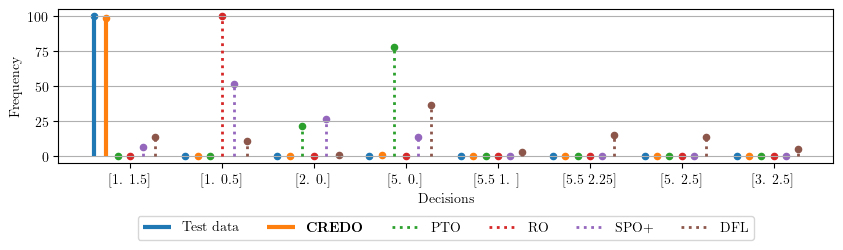

In [111]:
import matplotlib.pyplot as plt

scale = 0.8
name = ['Test data', r'\textbf{CREDO}', 'PTO', 'RO', 'SPO+', 'DFL']
cmap = plt.cm.tab10

plt.figure(figsize=[10, 2])
ax = plt.gca()
xs = np.arange(len(all_decisions))
for i in range(len(results)):   # [ num_decisions ]
    if i != 0:
        item =  results[i - 1]
    else:
        item = []
        for j in range(100):
            mask = results[-1][j, :, :][:, None, :] == all_decisions[None, :, :] # [ nte, num_decisions, z_dim ]
            mask = mask.all(2)      # [ nte, num_decisions ]
            mask    = mask.sum(0)   # [ num_decisions ]
            index   = mask.argmax()
            item.append(all_decisions[index])
        item = np.array(item)
    count = count_decision(item, all_decisions)
    for j in range(len(xs)):
        ax.vlines(x = xs[j] - 0.5 * scale + i * scale / len(results),
                ymin = 0,
                ymax = count[j],
                color = cmap(i),
                lw = 3 if i <= 1 else 2,
                ls = '-' if i <= 1 else 'dotted',
                label = name[i] if j == 0 else None)
    ax.scatter(xs - 0.5*scale + i * scale / len(results),
               count, color=cmap(i), s = 20)
ax.set_ylabel('Frequency')
ax.set_xticks(xs, all_decisions)
ax.set_xlabel('Decisions')
ax.grid(axis='y')
plt.legend(bbox_to_anchor = [0.5, -0.3], ncol = 6,  loc = 'upper center')
plt.show()

# Real

## Runners

In [61]:
from sklearn.model_selection import train_test_split

def transform_real_data(Y, Yte, tau, loss, beta, cost, budget, num_sub = None):
    '''
    Transform the parameters to inputs of the experiment runner 

    Args:
    - Y:    [ nY, num_sub ]
    - Yte:  [ nte, num_sub ]
    - tau:  [ num_sub ]
    - loss: [ num_sub ]
    - beta:     scalar, smoothin coefficient

    Returns:
    - Y:    [ nY, num_sub ]
    - Yte:  [ nY, num_sub ]
    - A:    [ 1+2*num_sub, num_sub ]
    - b:    [ 1+2*num_sub ]
    '''
    if num_sub is None:
        num_sub = len(tau)
    # add negative sign to turn into maximization
    Y_      = - loss / (1 + np.exp( - beta * (Y - tau)))      # [ batch_size, num_sub ]
    Yte_    = - loss / (1 + np.exp( - beta * (Yte - tau)))    # [ batch_size, num_sub ]

    # constructing the optimization parameters
    A0 = (- cost.T)[None, :]                # [ 1, num_sub ]
    b0 = (budget - cost.sum()).reshape(1)   # [ 1 ]
    A1  = np.identity(num_sub) * -1      # [ num_sub, num_sub ]
    b1  = np.zeros(num_sub)              # [ num_sub ]
    A2  = np.identity(num_sub)           # [ num_sub, num_sub ]
    b2  = np.ones(num_sub)                  # [ num_sub ]

    A = np.concatenate([A0, A1, A2], 0)
    b = np.concatenate([b0, b1, b2])

    return Y_, Yte_, A, b

# helper function
def generate_basis_directions(n):
    directions = []
    for i in range(n):
        vec = np.zeros(n)
        vec[i] = 1
        directions.append(vec.copy())
        vec[i] = -1
        directions.append(vec.copy())
    return np.array(directions)

def real_decision(Y, Yte, ncomp, k, A, b, lr = 1e-1, niter = 100, verbose = False, save_folder = None):
    '''
    Y, Yte, A, b should all be pos-processed

    Y:      [ ntr+ncal, z_dim ] training and calibration data
    Yte:    [ nte, z_dim ] testing data
    '''

    # 1/2 random splitting. NOTE: there is randomness here!
    Ytr, Ycal = train_test_split(Y, test_size=0.33, shuffle=True)  # [ ntr, data_dim ] and [ ncal, data_dim ]

    '''Ground truth (z_real for Yte)'''
    z_real = []
    for i in range(Yte.shape[0]):
        kwds  = {
            'A':    A,
            'b':    b,
            'Y':    Yte[i]
        }
        opt = Optimization(**kwds)
        z_real_  = opt.get_action()
        z_real.append(z_real_)
    z_real = np.array(z_real)               # [ nte, z_dim ] 

    '''Our method'''
    placeholder_kwds = {
        'mu':       np.zeros([ncomp, Y.shape[1]]),
        'scale':    np.ones(ncomp),                                 # [ ncomp ] np, the variance of GMs 
        'weights':  np.ones(ncomp) / ncomp,    # [ ncomp ] np, the variance of GMs 
    }
    pred_sampler = GaussianMixtureSampler(**placeholder_kwds)
    model_kwds = pred_sampler.fit(Ytr, n_iter=100, return_kwds=True)
    kwds = {
        'A':    A,
        'b':    b,
        'kwds': model_kwds,
        'boundary_scale':   10
    }
    dra         = ConformalizedDecisionRiskAssessment(**kwds)
    all_decisions   = dra.vertices  # record all decisions, which is going to be used later...
    dra.calibrate(Ycal)
    a = dra.get_prob(K = k)         # [ num_decision ]
    a = all_decisions[np.argmax(a)] # [ z_dim ], the final decision

    '''PTO / Naive Prediction'''
    kwds  = {
        'A':    A,
        'b':    b,
        'Y':    Y.mean(0)
    }
    opt = Optimization(**kwds)
    b_  = opt.get_action()  # [ z_dim ], the final decision

    '''Robust Optimization (uncertainty region determined by CP)'''
    Y_pred  = Ytr.mean(0)
    scores  = np.linalg.norm(Y_pred[None, :] - Ycal, ord = np.inf, axis=1) # [ ncal ] 
    q       = np.quantile(scores, 0.95)   # scalar  
    kwds  = {
        'A':    A,
        'b':    b,
        'C':    generate_basis_directions(Y.shape[1]),
        'd':    np.concatenate([np.array([Y_pred[i] + q, -Y_pred[i] + q]) for i in range(Y.shape[1])])
    }
    ro = RobustOptimization(**kwds)
    d_ = ro.get_action()

    '''Smart Predict-Then-Optimize (SPO)'''
    kwds  = {
        'A':    A,
        'b':    b,
        'verbose':  verbose
    }
    fit_kwds = {
        'Y':        Y,
        'lr':       lr,
        'niter':    niter,
        'save_folder':  save_folder
    }

    spo = SPO(**kwds)
    Y_hats = spo.fit(**fit_kwds) # trajectories of estimated Yhat
    e = spo.get_action()

    '''Decision Focused Learning (DFL)'''
    kwds  = {
        'A':    A,
        'b':    b,
        'verbose':  verbose
    }
    fit_kwds = {
        'Y':        Y,
        'lr':       lr,
        'niter':    niter,
        'patience': niter # TODO
    }
    dfl = DFL(**kwds)
    Y_hats = dfl.fit(**fit_kwds)
    f = dfl.get_action()

    return a, b_, d_, e, f, z_real  # they are CREDO, PTO, RO, SPO+, DFL --- all scalars

def sliding_window_runner(Yall, ncomp, beta):

    Y, Yte = train_test_split(Yall, test_size=0.33, shuffle=True) 

    num_sub = Y.shape[-1]
    transform_kwds = {
        'Y'       : Y,
        'Yte'     : Yte,
        'tau'     : Y.mean(0),          # Meaning: if it keeps going like this then it is going to fail
        'loss'    : np.ones(num_sub),   # Equal loss for all substations
        'beta'    : beta,                # No smoothing. NOTE: can be tuned
        'cost'    : np.ones(num_sub),
        'budget'  : num_sub / 2
    }

    Y, Yte, A, b = transform_real_data(**transform_kwds) # [ num_dates, num_subs ]

    kwds = {
        'Y':        Y,
        'Yte':      Yte,
        'ncomp':    ncomp,
        'k':        100,
        'A':        A,
        'b':        b,
        'lr':       1e-1,
        'niter':    100,
        'verbose':  False,
        'save_folder':  f'cache/real'
    }

    a, b_, c, d, e, z_real = real_decision(**kwds)

    results = [ a, b_, c, d, e, z_real ]

    return results

## Metrics

In [88]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
from tqdm import tqdm

df      = pd.read_csv(r'data\real_records.csv', index_col=0)
df_     = pd.read_csv(r'data\real_gdf.csv')
df_['geometry'] = df_['geometry'].apply(wkt.loads)
gdf    = gpd.GeoDataFrame(df_, geometry='geometry') 

Yall = df.values

subnames = gdf['substation']

In [89]:
ntrial  = 2022 - 2010 
skip =    12
span =    24 

config()

results = []
for i in tqdm(range(ntrial)):
    Y_trial     = Yall[::-1][i*skip:i*skip+span] 
    # start_date  = pd.Timestamp(f'{2022 - i :.0f}-12-31')
    # end_date    = pd.Timestamp(f'{2024 - i :.0f}-12-31')
    decisions = sliding_window_runner(Y_trial, ncomp=3, beta=0.5)

    for i in range(len(decisions) - 1):
        item    = decisions[i]
        z_real  = decisions[-1] 
        decisions[i] = empirical_decision_rank(item, z_real) # scalar
    results.append(decisions[:-1])
results = np.array(results)

  0%|          | 0/12 [00:00<?, ?it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.28it/s]c:\Users\wenbi\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 92%|█████████▏| 11/12 [00:03<00:00,  3.34it/s]c:\Users\wenbi\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 12/12 [00:03<00:00,  3.27it/s]


In [90]:
names = [ 'CREDO', 'PTO', 'RO', 'SPO+', 'DFL' ]

results_ = results.T
for i in range(len(results_)):
    mean = results_[i].mean(0)
    std = results_[i].std(0)
    print(f'{names[i]}: {mean :.2f} \\pm {std : .2f}')

CREDO: 1.50 \pm  0.76
PTO: 1.67 \pm  1.31
RO: 2.67 \pm  1.31
SPO+: 2.00 \pm  1.22
DFL: 2.33 \pm  1.31


## Visualize CREDO Choices

In [99]:
ncomp   =   3
Y       =   Yall 
num_sub =   4
beta    =   0.5
k =         100 

transform_kwds = {
    'Y'       : Y,
    'Yte'     : Y,
    'tau'     : Y.mean(0),          # Meaning: if it keeps going like this then it is going to fail
    'loss'    : np.ones(num_sub),   # Equal loss for all substations
    'beta'    : beta,                # No smoothing. NOTE: can be tuned
    'cost'    : np.ones(num_sub),
    'budget'  : num_sub / 2
}

Y, _, A, b =    transform_real_data(**transform_kwds) # [ num_dates, num_subs ]
Ytr, Ycal =     train_test_split(Y, test_size=0.5, shuffle=True) 

placeholder_kwds = {
    'mu':       np.zeros([ncomp, Y.shape[1]]),
    'scale':    np.ones(ncomp),                                 # [ ncomp ] np, the variance of GMs 
    'weights':  np.ones(ncomp) / ncomp,    # [ ncomp ] np, the variance of GMs 
}
pred_sampler = GaussianMixtureSampler(**placeholder_kwds)
model_kwds = pred_sampler.fit(Ytr, n_iter=100, return_kwds=True)
kwds = {
    'A':    A,
    'b':    b,
    'kwds': model_kwds,
    'boundary_scale':   10
}
dra         = ConformalizedDecisionRiskAssessment(**kwds)
all_decisions   = dra.vertices  # record all decisions, which is going to be used later...
dra.calibrate(Ycal)
probs = dra.get_prob(K = k)     # [ num_decision ]

In [105]:
indices =       np.argsort(probs)[::-1]
top_decisions = all_decisions[indices]

100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


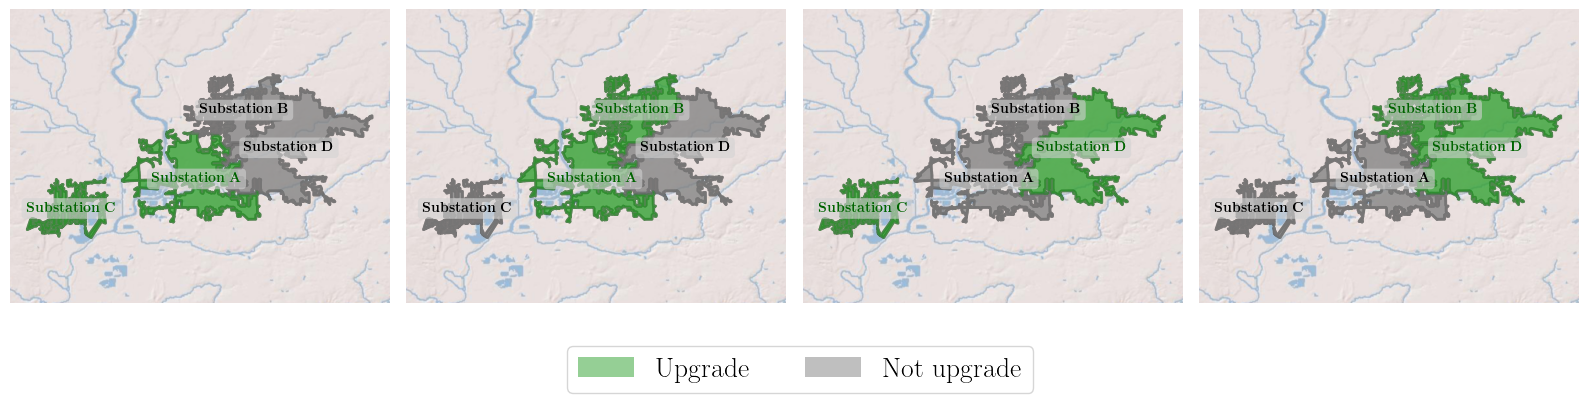

In [ ]:
import contextily as ctx
from tqdm import tqdm

keep_top = 4

indices = []
for i in range(4):
    if subnames[i] == 'Willams Street':
        mask = gdf['substation'] == 'Williams'
    else:
        mask = gdf['substation'] == subnames[i]
    # index = np.where(mask)[0].item()
    index = np.where(mask)[0].item()
    indices.append(index)

indices = np.array(indices)

letters = [ r'\textbf{A}', r'\textbf{B}', r'\textbf{C}', r'\textbf{D}'  ]

scale = 0.8
fig, axes = plt.subplots(1, keep_top, figsize=[20*scale, 5*scale])
for i in tqdm(range(keep_top)):
    ax = axes[i]
    mask = top_decisions[i]

    gdf_                   = gdf.iloc[indices, :].copy()
    gdf_.loc[:, 'color']   = mask

    gdf_['color'] = gdf_['color'].map({1: 'tab:green', 0: 'gray'})

    # gdf_.plot(ax= ax, edgecolor='black', lw = 2, alpha = 0.5, column = 'color')
    gdf_.plot(ax= ax, facecolor=gdf_['color'], edgecolor='black', lw = 2, alpha = 0.5)
    gdf_.plot(ax= ax, facecolor=gdf_['color'], edgecolor=gdf_['color'], lw = 2, alpha = 0.5)

    margin = 0.03
    ax.set_ylim(ax.get_ylim()[0] - margin, ax.get_ylim()[1] + margin)

    # add text
    for j in range(len(gdf_)):
        centroid = gdf_.iloc[j, :]['geometry'].centroid
        coords_centroid = np.array([centroid.x, centroid.y])
        ax.text(*coords_centroid.T, r'\textbf{Substation} ' + letters[j], ha = 'center', va = 'center',
                color = '#006400' if mask[j] else 'black',
                bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round,pad=0.3', alpha = 0.6))

    ctx.add_basemap(ax, attribution='', crs = 'EPSG:4326', source=ctx.providers.Esri.WorldShadedRelief)
    ax.axis('off')

    ax.bar(0, 1, lw = 2, alpha = 0.5, color=  'tab:green', label = 'Upgrade')
    ax.bar(0, 1, lw = 2, alpha = 0.5, color=  'gray', label = 'Not upgrade')

plt.tight_layout()
plt.legend(bbox_to_anchor = [-0.4, -0.1], ncol = 2, fontsize = 20)

plt.show()